# Notebook #2: Transformación y Preprocesamiento

- En este notebook, se realiza la limpieza, transformación y preparación de los datos para ser utilizados por un modelo.

- Todas las funciones aquí utilizadas encuentran su soporte en [este soporte](../src/soporte_prep.py). Las líneas de código que implican guardado de archivos han sido comentadas.

- El primer paso será importar las librerías necesarias:

In [1]:
%load_ext autoreload
%autoreload 2

# Librerías para tratamiento de datos

import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None) # Parámetros que modifica la visualización de los DFs
pd.set_option("display.float_format", "{:.2f}".format)

# Librerías para el acceso a variables y funciones
import sys
sys.path.append("../")
from src import soporte_preprocesamiento as sp
from src import soporte_estadistica as sa
from src import soporte_encoding as se
from src import soporte_scaling as ss
from src import soporte_mongo as sm

# Librerías para trabajar con distintos formatos de archivos
import pickle
import json

# Librería para ignorar avisos
import warnings
warnings.filterwarnings("ignore") # Ignora TODOS los avisos

- Ahora importaremos los archivos GeoJSON generados en el notebook #1, y trataremos cada archivo por separado.
- En el caso de los datos de ventas, únicamente analizaremos su contenido, serán los datos de alquiler que trataremos en detalle para crear un modelo de regresión.

1. **Análisis exploratorio de datos (EDA):**
   - Visualizar la distribución de las principales variables.
   - Explorar relaciones entre las características y la variable objetivo (`price`).

2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.
   - Eliminar duplicados si existen.
   - Asegurar que las variables tienen el tipo de dato correcto.

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.
   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.


## DataFrame Venta
### Análisis Exploratorio de Datos

- Importamos el dataframe creado en el notebook #1.

In [21]:
df_sale = pd.read_csv('../data/raw/idealista_sale2.csv', index_col=0)
df_sale.head(1)

,codigo,latitud,longitud,precio,precio_por_zona,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,parking,estado,direccion,descripcion,fecha,anunciante,contacto,cantidad_imagenes,urls_imagenes,tags_imagenes
0,104792745,41.70,-0.87,149900.00,1180.00,piso,True,4,True,127.00,3,2,False,False,False,True,True,good,"carretera de Huesca, 21","Junto a la Academia General Militar, en carret...",NaN,"Fincas Ruiz, Jose",876 21 08 84,39,['https://img4.idealista.com/blur/WEB_LISTING-...,"['views', 'livingRoom', 'kitchen', 'facade', '..."


- Como primer paso, eliminaremos la columna "Fecha", por no contener valores.

In [22]:
df_sale.drop(columns="fecha", inplace=True)

- Con una función de exploración, obtendremos una vista general del conjunto de datos:

In [23]:
sp.exploracion_datos(df_sale)

El número de filas es 480 y el número de columnas es 25

----------

En este conjunto de datos tenemos 11 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


exterior             21.46
planta               21.04
ascensor             16.88
aire_acondicionado    0.83
trastero              2.71
terraza               5.62
patio                 6.88
dtype: float64


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
codigo,480.00,105348986.45,4716727.43,32921505.00,105381559.00,106747185.00,107071320.50,107245266.00
latitud,480.00,41.66,0.02,41.59,41.65,41.65,41.66,41.76
longitud,480.00,-0.90,0.05,-1.09,-0.90,-0.89,-0.87,-0.78
precio,480.00,114140.33,25164.93,60000.00,92900.00,119995.00,135000.00,150000.00
precio_por_zona,480.00,1615.49,584.40,60.00,1220.50,1609.50,2027.50,2956.00
tamanio,480.00,87.20,123.61,34.00,58.00,69.00,84.00,2500.00
habitaciones,480.00,2.32,0.98,0.00,2.00,2.00,3.00,6.00
banios,480.00,1.09,0.34,0.00,1.00,1.00,1.00,3.00
cantidad_imagenes,480.00,19.86,11.55,1.00,11.75,18.00,26.00,68.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
tipo,480,6,piso,383
exterior,377,2,True,316
planta,379,12,2,93
ascensor,399,2,True,202
aire_acondicionado,476,2,False,338
trastero,467,2,False,383
terraza,453,2,False,292
patio,447,2,False,409
estado,480,3,good,364
direccion,480,350,Casetas - Garrapinillos - Monzalbarba,12



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 0 to 479
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   codigo              480 non-null    int64  
 1   latitud             480 non-null    float64
 2   longitud            480 non-null    float64
 3   precio              480 non-null    float64
 4   precio_por_zona     480 non-null    float64
 5   tipo                480 non-null    object 
 6   exterior            377 non-null    object 
 7   planta              379 non-null    object 
 8   ascensor            399 non-null    object 
 9   tamanio             480 non-null    float64
 10  habitaciones        480 non-null    int64  
 11  banios              480 non-null    int64  
 12  aire_acondicionado  476 non-null    object 
 13  trastero            467 non-null    object 
 14  terraza             453 non-null    object 
 15

None

- Habiendo detectado los valores nulos, y estando todos en columnas categóricas, los rellenaremos con una nueva categoría "ND".

In [24]:
columnas_fillna_sale = ["aire_acondicionado", "exterior", "planta", "ascensor", "trastero", "terraza", "patio"]
df_sale[columnas_fillna_sale] = df_sale[columnas_fillna_sale].fillna("ND")

- Comprobamos que no tenemos más valores nulos.

In [25]:
df_sale.isna().sum()

codigo                0
latitud               0
longitud              0
precio                0
precio_por_zona       0
tipo                  0
exterior              0
planta                0
ascensor              0
tamanio               0
habitaciones          0
banios                0
aire_acondicionado    0
trastero              0
terraza               0
patio                 0
parking               0
estado                0
direccion             0
descripcion           0
anunciante            0
contacto              0
cantidad_imagenes     0
urls_imagenes         0
tags_imagenes         0
dtype: int64

- Vamos ahora a eliminar los duplicados y comprobar que se hayan eliminado.

In [26]:
df_sale.drop_duplicates(inplace=True)

In [27]:
df_sale.duplicated().sum()

0

- Vamos ahora a analizar las variables numéricas y categóricas, para lo cual, utilizamos primero una función para separarlas.

In [24]:
df_num_sale, df_cat_sale = sp.separar_dataframe(df_sale)

- Debemos identificar primero las variables que, a pesar de ser numéricas, no interesa analizar, como lo son el código, por ser único, y la latitud y la longitud, que corresponden a datos geográficos. Las eliminamos del dataframe.

In [25]:
df_num_sale.drop(columns= ["codigo", "latitud", "longitud"], inplace=True)

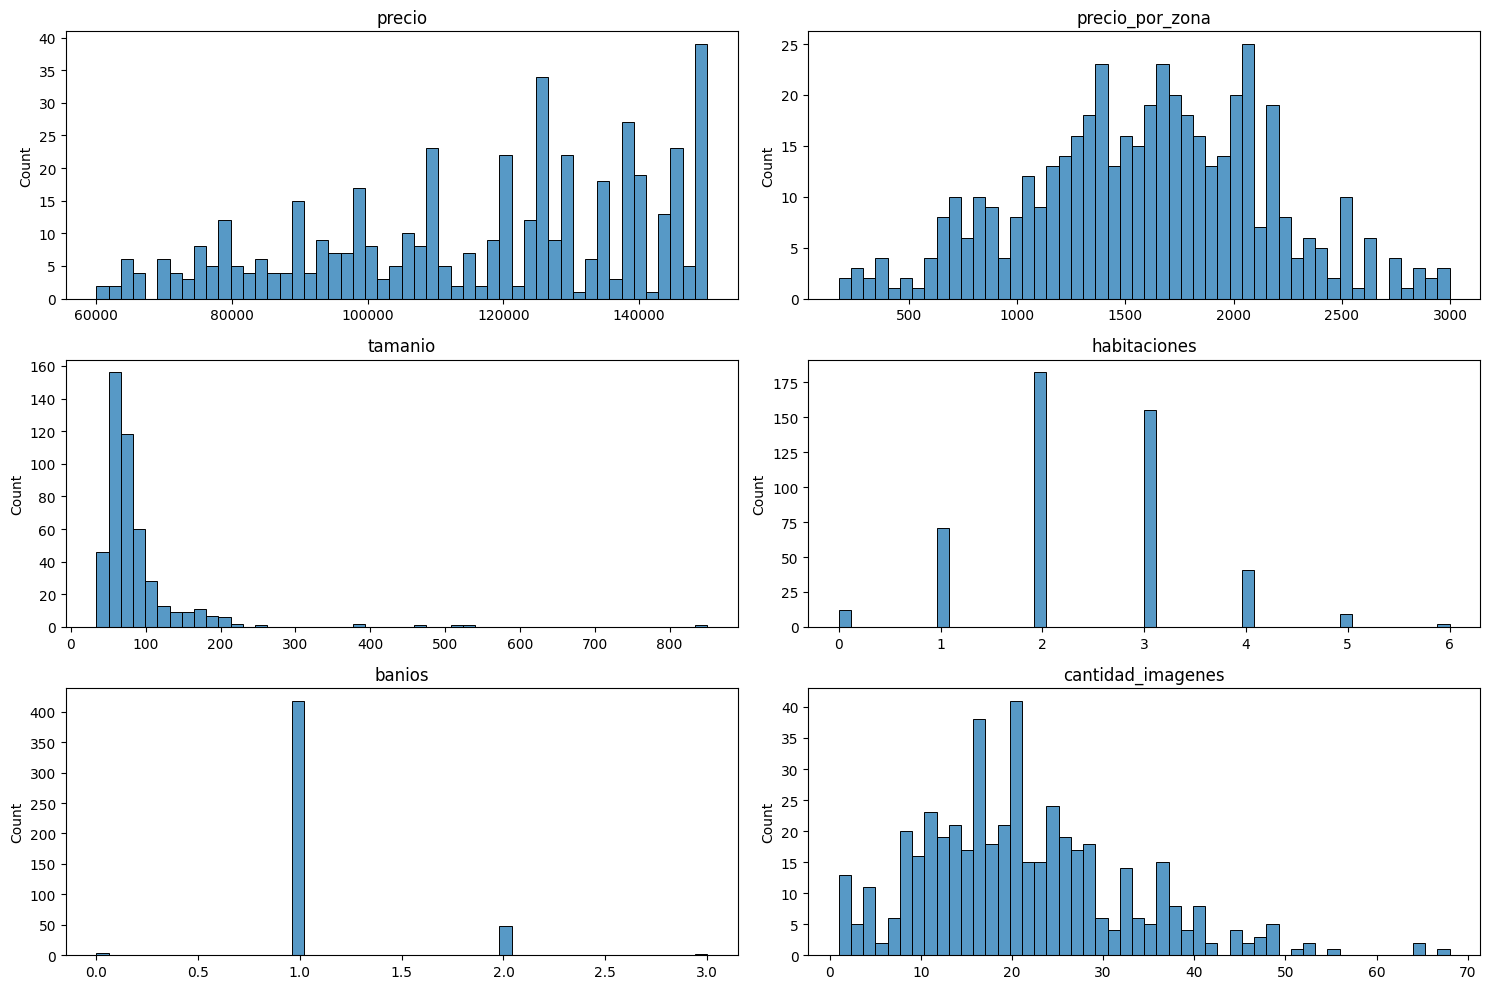

In [26]:
sp.plot_numericas(df_num_sale)

- En el caso del precio, precio por zona, tamaño y cantidad de imágenes, vemos que, se comportan como numéricas, existiendo muchos datos que se encuentran repartidos en el rango de las gráficas.

- Un comportamiento distinto observamos para las habitaciones y los baños, que, muestran pocas categorías, y en el caso de los baños, se concentran principalmente en una. Esto nos indica que, a pesar de ser numéricas, su comportamiento es de categóricas.

- Vamos a analizar ahora las categóricas, pero antes, vamos a eliminar las columnas "dirección", "descripción", "urls_imagenes" y "tags_imagenes", por tratarse de características únicas, que no tiene sentido graficar. También eliminaremos la variable "anunciante", por el elevado número de categorías que contiene.

In [27]:
df_cat_sale.drop(columns=["direccion","descripcion","anunciante","contacto","urls_imagenes","tags_imagenes"], inplace=True)

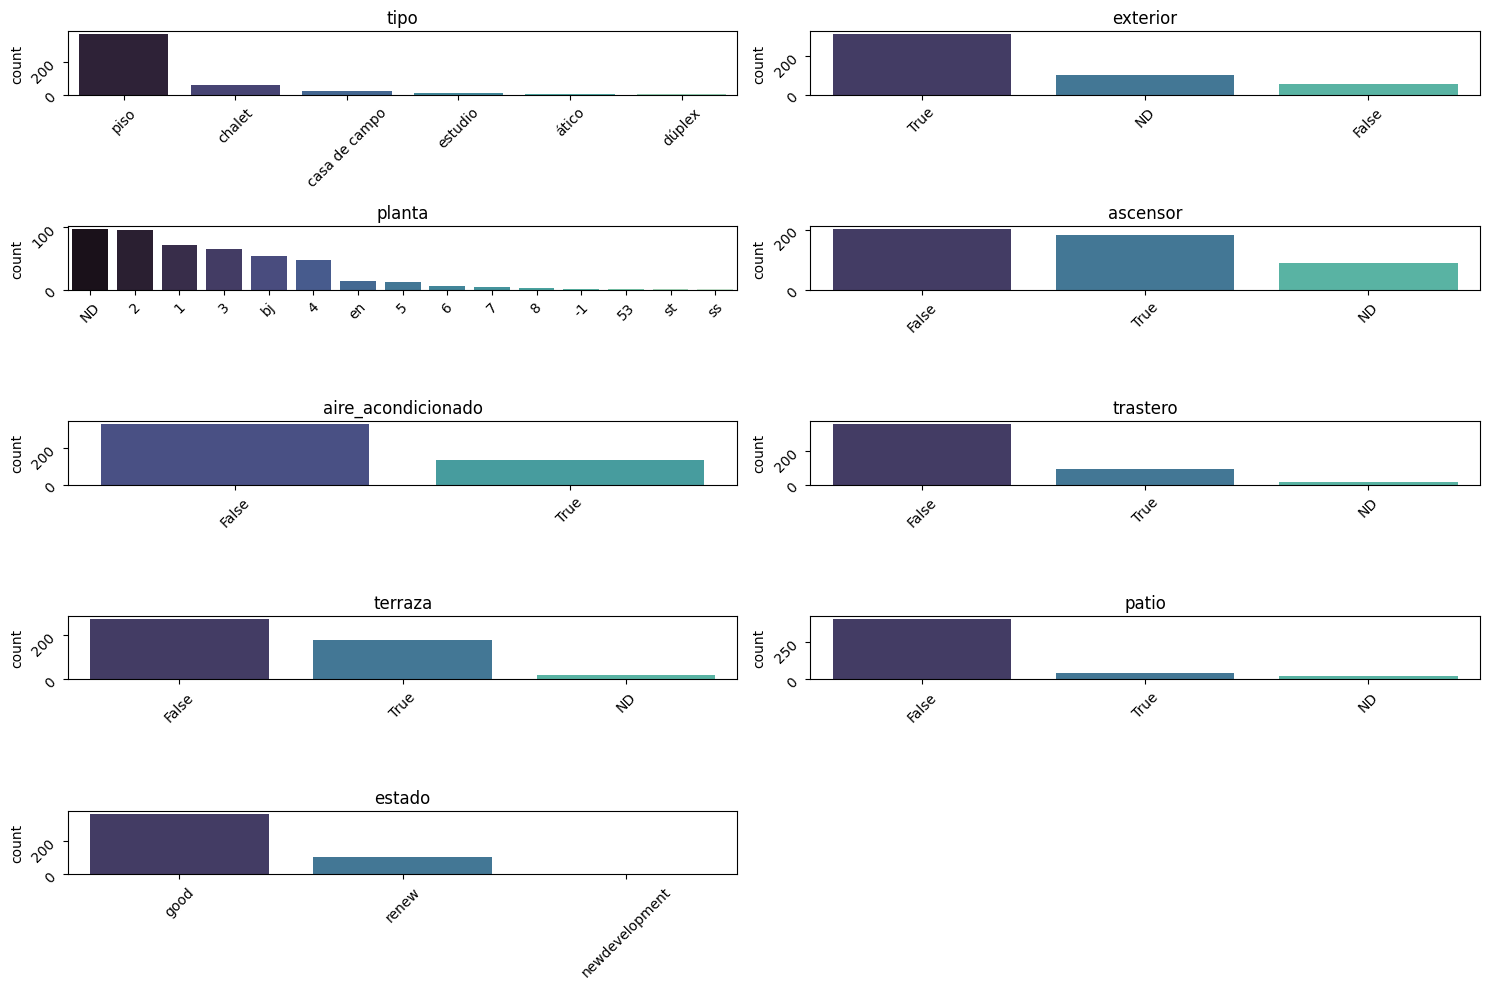

In [28]:
sp.plot_cat(df_cat_sale)

- En este caso vemos que, las variables categóricas se comportan como tales, y en general, se reparten entre las categorías, guardando relación con el estado de las viviendas en la provincia de Guadalajara.

- La excepción es anunciantes, que cuenta con una gran cantidad de categorías, por lo tanto, las eliminaremos del modelo.

- Como hemos mencionado antes, sobre estos datos no realizaremos operaciones adicionales, por cuanto no se utilizarán para crear un modelo, únicamente añadiremos el distrito.
______________________

- Para poder asignar las coordenadas de cada vivienda a un distrito, transformamos la latitud y la longitud de entrada a un geopunto, y uniremos el nuevo GDF con nuestro GDF de distritos. Asignamos el tipo de CRS y guardamos en un archivo de tipo `geojson`.
- También vamos a eliminar la columna 'tags_imagenes', por cuanto no la vamos a utilizar.

In [11]:
gdf_distritos = gpd.read_file("../data/transformed/gdf_distritos.geojson")

In [12]:
gdf_sale = gpd.GeoDataFrame(df_sale, geometry=gpd.points_from_xy(df_sale.longitud, df_sale.latitud))
gdf_sale.crs = "EPSG:4326"

In [28]:
gdf_sale_join = gpd.sjoin(gdf_sale, gdf_distritos, how="inner", predicate="within")
gdf_sale_join.drop(columns=["index_right", "latitud", "longitud", "tags_imagenes"], inplace=True)
gdf_sale_join.head(1)

,codigo,precio,precio_por_zona,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,parking,estado,direccion,descripcion,anunciante,contacto,cantidad_imagenes,urls_imagenes,geometry,distrito
0,104792745,149900.00,1180.00,piso,True,4,True,127.00,3,2,False,False,False,True,True,good,"carretera de Huesca, 21","Junto a la Academia General Militar, en carret...","Fincas Ruiz, Jose",876 21 08 84,39,['https://img4.idealista.com/blur/WEB_LISTING-...,POINT (-0.86935 41.6973),Distrito Rural


In [29]:
gdf_sale_join["estado"].value_counts(normalize=True)

estado
good             0.77
renew            0.22
newdevelopment   0.01
Name: proportion, dtype: float64

- Como parte del dataset, se ha identificado una gran cantidad de viviendas cuyo estado es "renew", entorno a un 20%.  Un análisis más detallado de las mismas, nos confirma que, en la mayoría de los casos, requieren una reforma total. Dado que este tipo de inversión es completamente distinta, por sus implicaciones, las eliminaremos del conjunto de datos.

- También alineado con el cliente objetivo del proyecto, eliminaremos los registros correspondientes a "casas de campo", que corresponden, en este caso, a aproximadamente un 4% del dataset (13 viviendas).

- Por su parte, la columna cantidad de imágenes no aporta al análisis de rentabilidad, así que vamos a eliminarla como paso previo a guardar el dataframe.

In [30]:
gdf_sale_join["tipo"].value_counts(normalize=True)

tipo
piso            0.79
chalet          0.12
casa de campo   0.05
estudio         0.02
ático           0.01
dúplex          0.01
Name: proportion, dtype: float64

In [31]:
gdf_sale_join.drop(index=gdf_sale_join[gdf_sale_join["tipo"]=="casa de campo"].index, inplace=True)

In [32]:
gdf_sale_join.drop(index=gdf_sale_join[gdf_sale_join["estado"]=="renew"].index, inplace=True)

In [33]:
gdf_sale_join.drop(columns="cantidad_imagenes", inplace=True)

In [34]:
gdf_sale_join.shape

(352, 23)

### Carga a Mongo

In [35]:
bd = sm.conectar_a_mongo("ProyectoRentabilidad")
sm.eliminar_coleccion(bd, "venta") # comprobamos o eliminamos la colección si ya existe, para evitar duplicados.
sm.subir_geodataframe_a_mongo(bd, gdf_sale_join, "venta")

bd.client.close()

GeoDataFrame subido a la colección: venta


## DataFrame Alquiler
### Análisis Exploratorio de Datos

In [39]:
df_rent = pd.read_csv('../data/raw/idealista_rent.csv', index_col=0)
df_rent.head(1)

,codigo,latitud,longitud,precio,precio_por_zona,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,parking,estado,direccion,descripcion,fecha,anunciante,contacto,cantidad_imagenes,urls_imagenes,tags_imagenes
0,107028216,41.68,-1.02,750.00,6.00,piso,True,2,True,123.00,2,1,False,False,True,False,True,good,avenida Jota,En Garrapinillos tienes un Esplendido piso sem...,2025-01-15,"Re/Max Y Tú, Susana",876 21 09 00,39,['https://img4.idealista.com/blur/WEB_LISTING-...,"['livingRoom', 'corridor', 'room', 'room', 'ro..."


- La primera operación que realizaremos es eliminar las columnas que no vamos a utilizar para el análisis, en este caso, el contacto, cantidad_imagenes, urls_imagenes y tags_imagenes.

- También eliminaremos las que representan valores únicos, como pueden ser código, la dirección, descripción, la fecha y el contacto.

In [40]:
df_rent.drop(columns=['codigo', 'direccion', 'descripcion', 'fecha', 'anunciante', 'contacto', 'cantidad_imagenes', 'urls_imagenes', 'tags_imagenes'], inplace=True)

- Vamos a explorar ahora los datos que contiene.

In [41]:
sp.exploracion_datos(df_rent)

El número de filas es 450 y el número de columnas es 17

----------

En este conjunto de datos tenemos 12 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


exterior             1.78
planta               2.44
ascensor             1.56
aire_acondicionado   0.44
trastero             0.89
terraza              1.11
patio                1.11
estado               0.44
dtype: float64


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
latitud,450.00,41.65,0.01,41.62,41.64,41.65,41.66,41.74
longitud,450.00,-0.89,0.02,-1.08,-0.90,-0.89,-0.88,-0.81
precio,450.00,916.44,238.28,470.00,750.00,850.00,1000.00,1500.00
precio_por_zona,450.00,11.85,3.74,5.00,9.25,11.00,13.00,29.00
tamanio,450.00,82.56,28.00,25.00,62.00,78.00,97.00,200.00
habitaciones,450.00,2.40,0.99,0.00,2.00,2.00,3.00,5.00
banios,450.00,1.35,0.51,1.00,1.00,1.00,2.00,4.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
tipo,450,6,piso,407
exterior,442,2,True,381
planta,439,18,2,86
ascensor,443,2,True,398
aire_acondicionado,448,2,True,252
trastero,446,2,False,364
terraza,445,2,False,230
patio,445,2,False,398
estado,448,2,good,445



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 0 to 449
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitud             450 non-null    float64
 1   longitud            450 non-null    float64
 2   precio              450 non-null    float64
 3   precio_por_zona     450 non-null    float64
 4   tipo                450 non-null    object 
 5   exterior            442 non-null    object 
 6   planta              439 non-null    object 
 7   ascensor            443 non-null    object 
 8   tamanio             450 non-null    float64
 9   habitaciones        450 non-null    int64  
 10  banios              450 non-null    int64  
 11  aire_acondicionado  448 non-null    object 
 12  trastero            446 non-null    object 
 13  terraza             445 non-null    object 
 14  patio               445 non-null    object 
 15

None

- Habiendo identificado 11 datos duplicados,  los vamos a eliminar y rellenar los nulos con una nueva categoría "ND".

In [42]:
df_rent.drop_duplicates(inplace=True)

In [43]:
df_rent.isna().sum()

latitud                0
longitud               0
precio                 0
precio_por_zona        0
tipo                   0
exterior               8
planta                11
ascensor               7
tamanio                0
habitaciones           0
banios                 0
aire_acondicionado     2
trastero               4
terraza                5
patio                  5
parking                0
estado                 2
dtype: int64

In [44]:
columnas_fillna_rent = ['exterior', 'planta', 'ascensor', 'aire_acondicionado', 'trastero', 'terraza', 'patio', 'estado']
df_rent[columnas_fillna_rent] = df_rent[columnas_fillna_rent].fillna("ND")

- Vamos ahora a asignar el distrito según las coordenadas geográficas, dado que, el indicado en el anuncio no se corresponde necesariamente con el correcto.

In [45]:
gdf_rent = gpd.GeoDataFrame(df_rent, geometry=gpd.points_from_xy(df_rent.longitud, df_rent.latitud))
gdf_rent.crs = "EPSG:4326"

In [46]:
gdf_rent_join = gpd.sjoin(gdf_rent, gdf_distritos, how="inner", predicate="within")
gdf_rent_join.drop(columns=["index_right", "latitud", "longitud"], inplace=True)

In [47]:
gdf_rent_join.head(1)

,precio,precio_por_zona,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,parking,estado,geometry,distrito
0,750.00,6.00,piso,True,2,True,123.00,2,1,False,False,True,False,True,good,POINT (-1.02434 41.6812),Distrito Rural


- Vamos ahora a visualizar las variables numéricas, categóricas y su relación, realizando primero la separación de variables según su tipo.

In [48]:
df_num_rent, df_cat_rent = sp.separar_dataframe(gdf_rent_join)

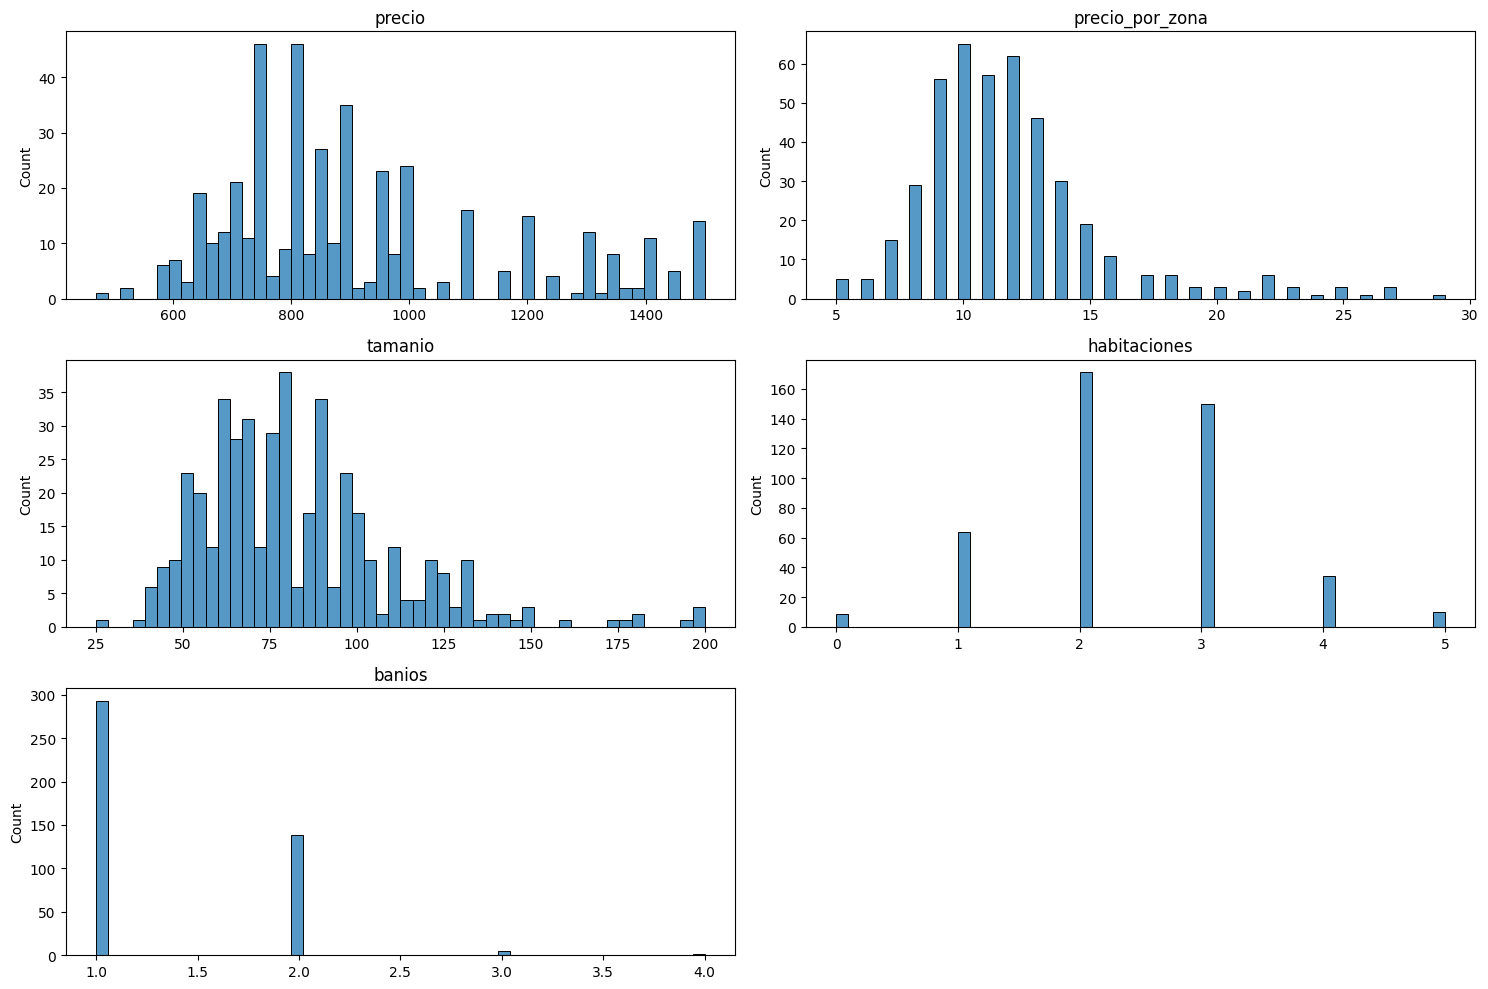

In [49]:
sp.plot_numericas(df_num_rent)

- Como primera observación, vemos que, las distribuciones no son normales, aunque en algunos casos podrían acercarse.

- De las gráficas podemos concluir que, en el caso del precio y el tamaño, se comportan como variables numéricas, estando distribuidas en el rango de las gráficas.

- Como hemos comentado en el caso de las habitaciones y los baños, se comportan más como categóricas, existiendo pocas categorías, de modo que, las convertiremos a string.

In [50]:
gdf_rent_join[["habitaciones", "banios"]] = gdf_rent_join[["habitaciones", "banios"]].astype(str)

- Veamos ahora las categóricas.

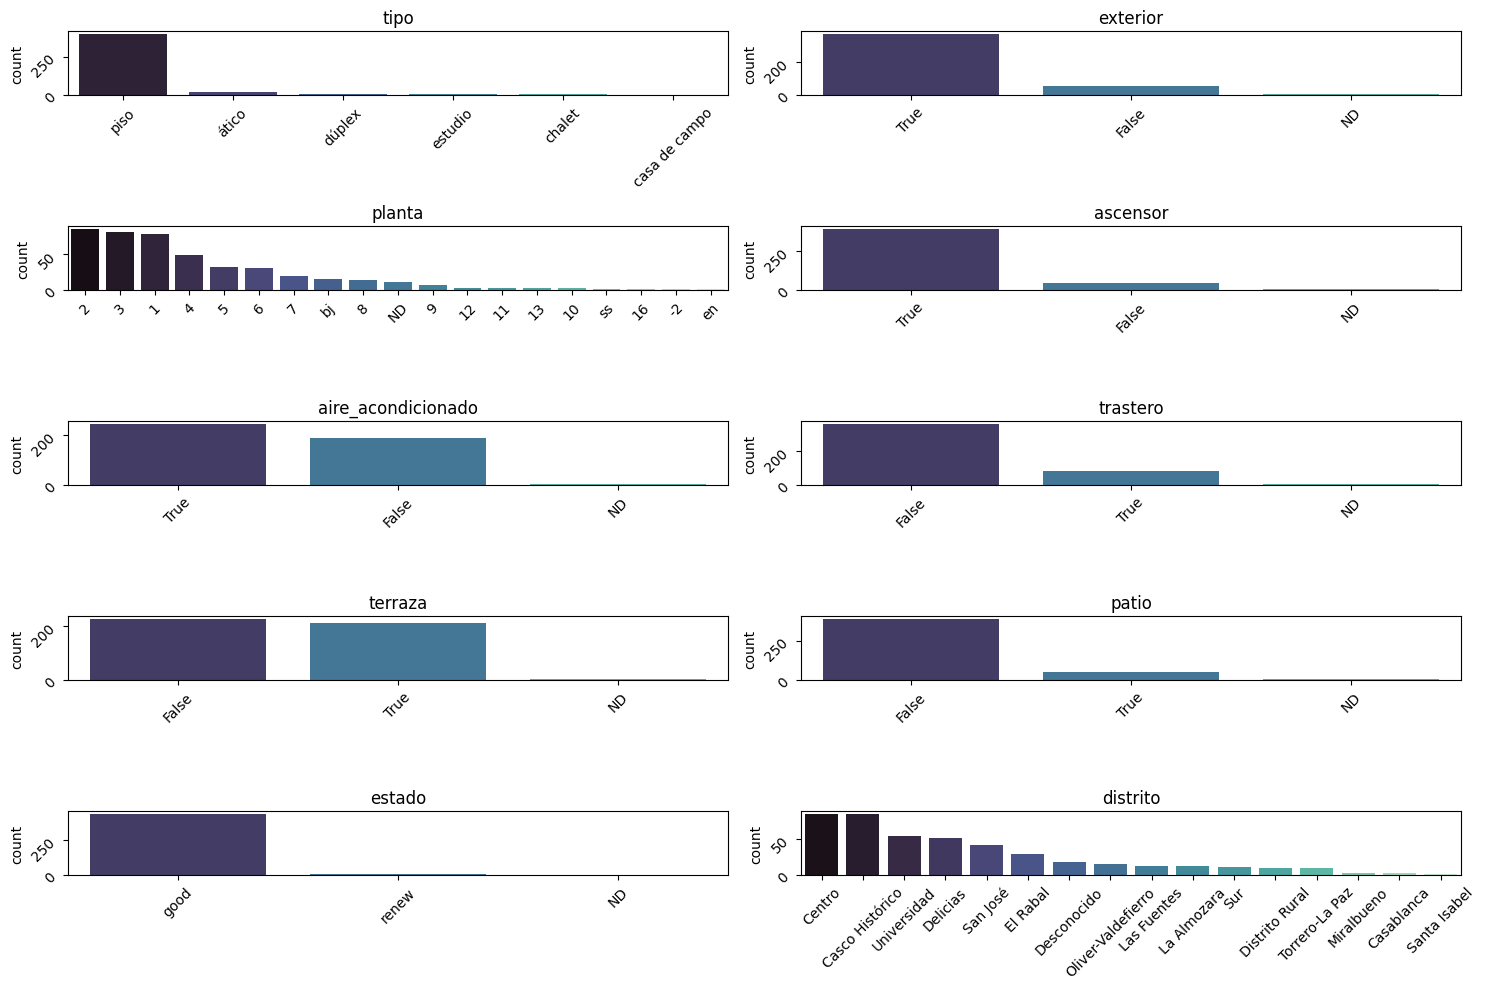

In [51]:
sp.plot_cat(df_cat_rent)

- En las gráficas podemos ver que, la mayoría de las viviendas son de tipo "piso" y se encuentran en estado "good". En el resto de variables, se encuentran distribuidas dentro de las categorías, siendo la mayoría exteriores, con ascensor, aire acondicionado, sin trastero y sin terraza.

- La mayoría de las viviendas disponibles están en los distritos Centro, casco Histórico, Universidad, Delicias y San José.

- Dado que con estos datos crearemos un modelo, vamos a analizar la relación entre las variables.

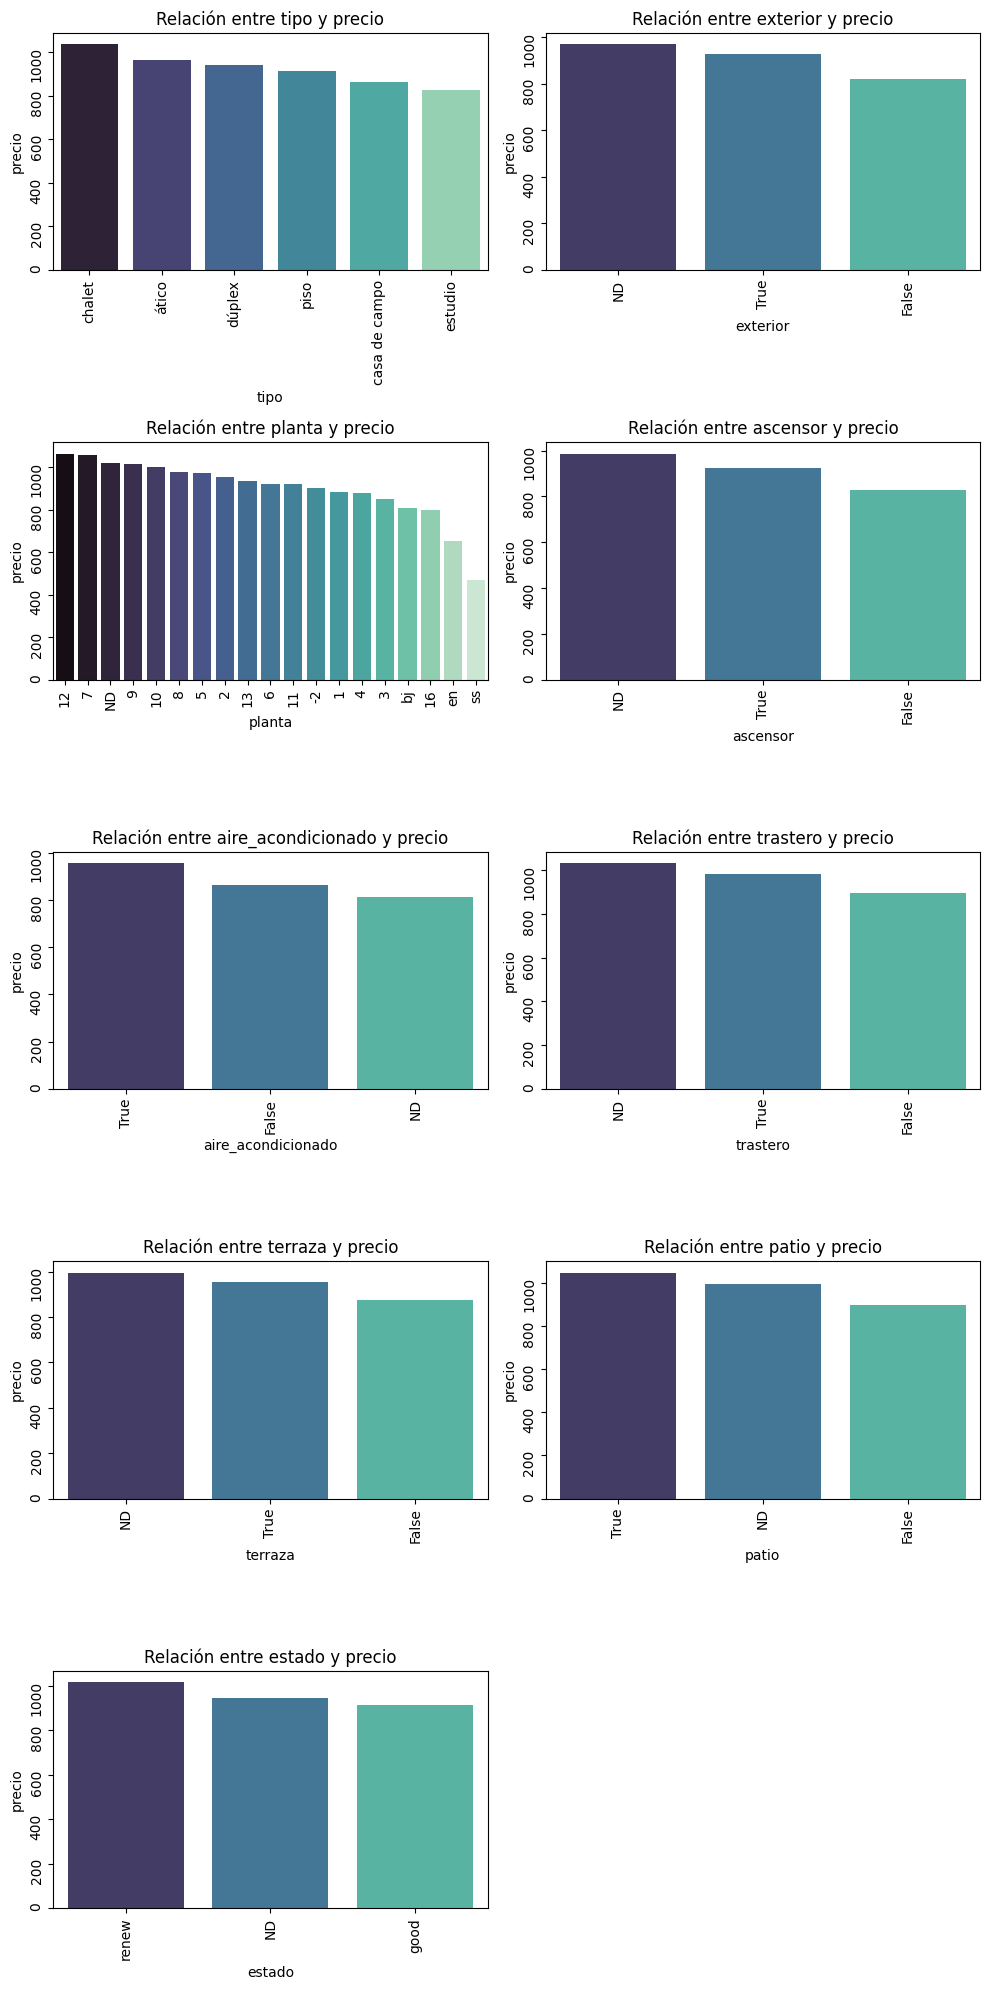

In [52]:
sp.relacion_vs_cat(df_rent, "precio", tamano_grafica=(10,20))

- En esta relación podemos ver que, excepto una, tienen sentido. Por ejemplo:
    - Los chalets son las viviendas más caras.
    - Los pisos exteriores, con aire acondicionado, trastero y terraza aumentan el precio del alquiler.

- En el caso del estado, no tiene sentido que, las viviendas que necesitan reforma sean más caras. Por ello, eliminaremos esta variable del modelo.

In [53]:
gdf_rent_join.drop(columns="estado", inplace=True)

- Para una visualización más sencilla, vamos a crear un nuevo DF sin las variables numéricas código, latitud y longitud. Hemos identificado previamente que, los baños y las habitaciones se comportan como categóricas, pero las mantendremos como numéricas para verlas en la matriz de correlación.

In [54]:
df_rent_graficas = df_rent.drop(columns=["latitud", "longitud"])

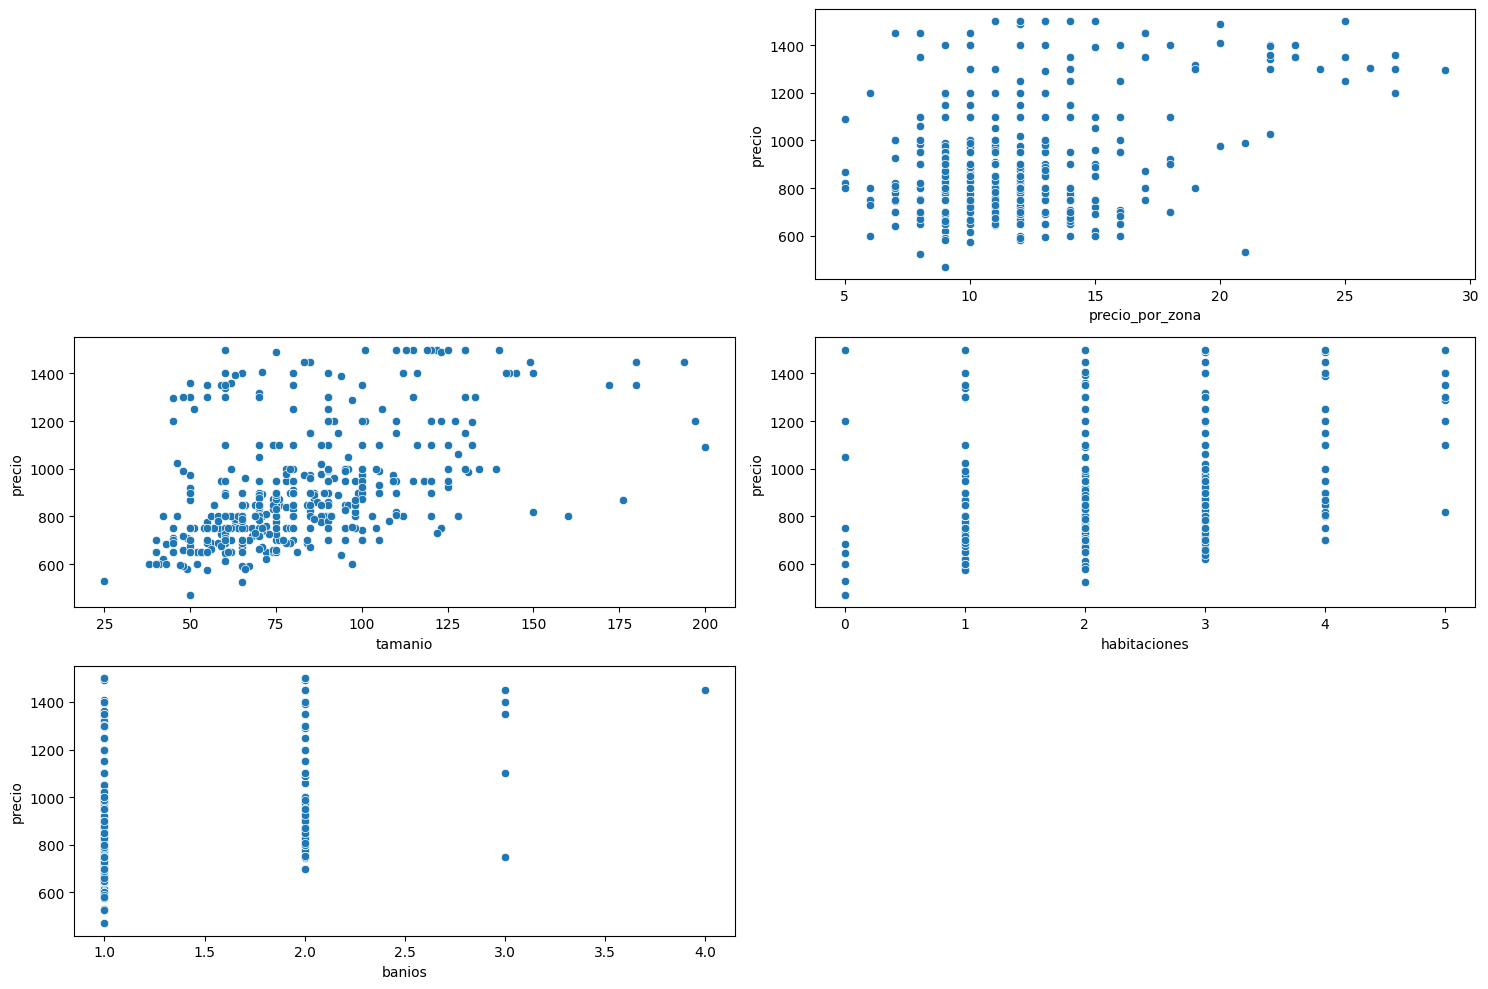

In [68]:
sp.relacion_vs_numericas(df_rent_graficas, "precio")

- En esta relación podemos ver que, en el caso del tamaño, en general, el precio aumenta a mayor cantidad de metros cuadrados, lo cual tiene sentido.

- El resto no las analizaremos por cuanto, hemos determinado que las habitaciones y los baños tiene comportamiento de numéricas, y el código, la latitud y la longitud no son variables para el análisis.

- En el caso del precio por zona, la gráfica no puede interpretarse, y aunque es una variable que puede ayudar a predecir el precio, no la tendremos como parte de los inputs, así que tendremos que eliminarla del modelo.

- Vamos ahora a analizar la matriz de correlación.

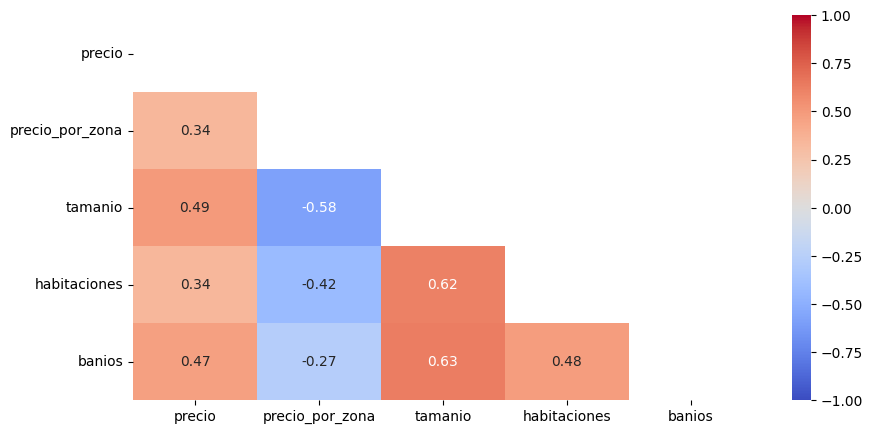

In [69]:
sp.matriz_correlacion(df_rent_graficas)

- En el caso del precio, observamos una correlación positiva moderada con el tamaño y los baños. Esto significa que, a mayor tamaño y mayor cantidad de baños, el precio aumenta. Es débil con las habitaciones y el precio por zona, lo que nos indica que, podrían ser variables que no tengan un efecto importante sobre el modelo.
- Es moderada y positiva la correlación del tamaño con las habitaciones y los baños. Esto es razonable, a mayor cantidad de metros cuadrados, más baños y habitaciones.
- Al observar el precio por zona, vemos una correlación negativa moderada con el tamaño, y débil con las habitaciones y los baños, lo cual tiene sentido.

### Encoding

Recordemos el dataframe.

In [70]:
gdf_rent_join.head(1)

,precio,precio_por_zona,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,geometry,distrito
0,750.00,6.00,piso,True,2,True,123.00,2,1,False,False,True,False,POINT (-1.02434 41.6812),Distrito Rural


- Dado que, las viviendas de alquiler sólo las utilizaremos para crear el modelo, eliminaremos la columna geometry.
- Eliminaremos además la columna 'precio_por_zona', por el motivo que habíamos explicado.

In [71]:
gdf_rent_join.drop(columns= "geometry", inplace=True)
gdf_rent_join.drop(columns= "precio_por_zona", inplace=True)

- Revisamos nuevamente los tipos de datos.

In [72]:
gdf_rent_join.dtypes

precio                float64
tipo                   object
exterior               object
planta                 object
ascensor               object
tamanio               float64
habitaciones           object
banios                 object
aire_acondicionado     object
trastero               object
terraza                object
patio                  object
distrito               object
dtype: object

- Tenemos 2 variables numéricas y 11 categóricas.

In [73]:
lista_col_categ = gdf_rent_join.select_dtypes(include="O").columns.tolist()

- Con un barplot, somos capaces de visualizar la relación entre la variable respuesta (precio) y el resto de las variables categóricas.

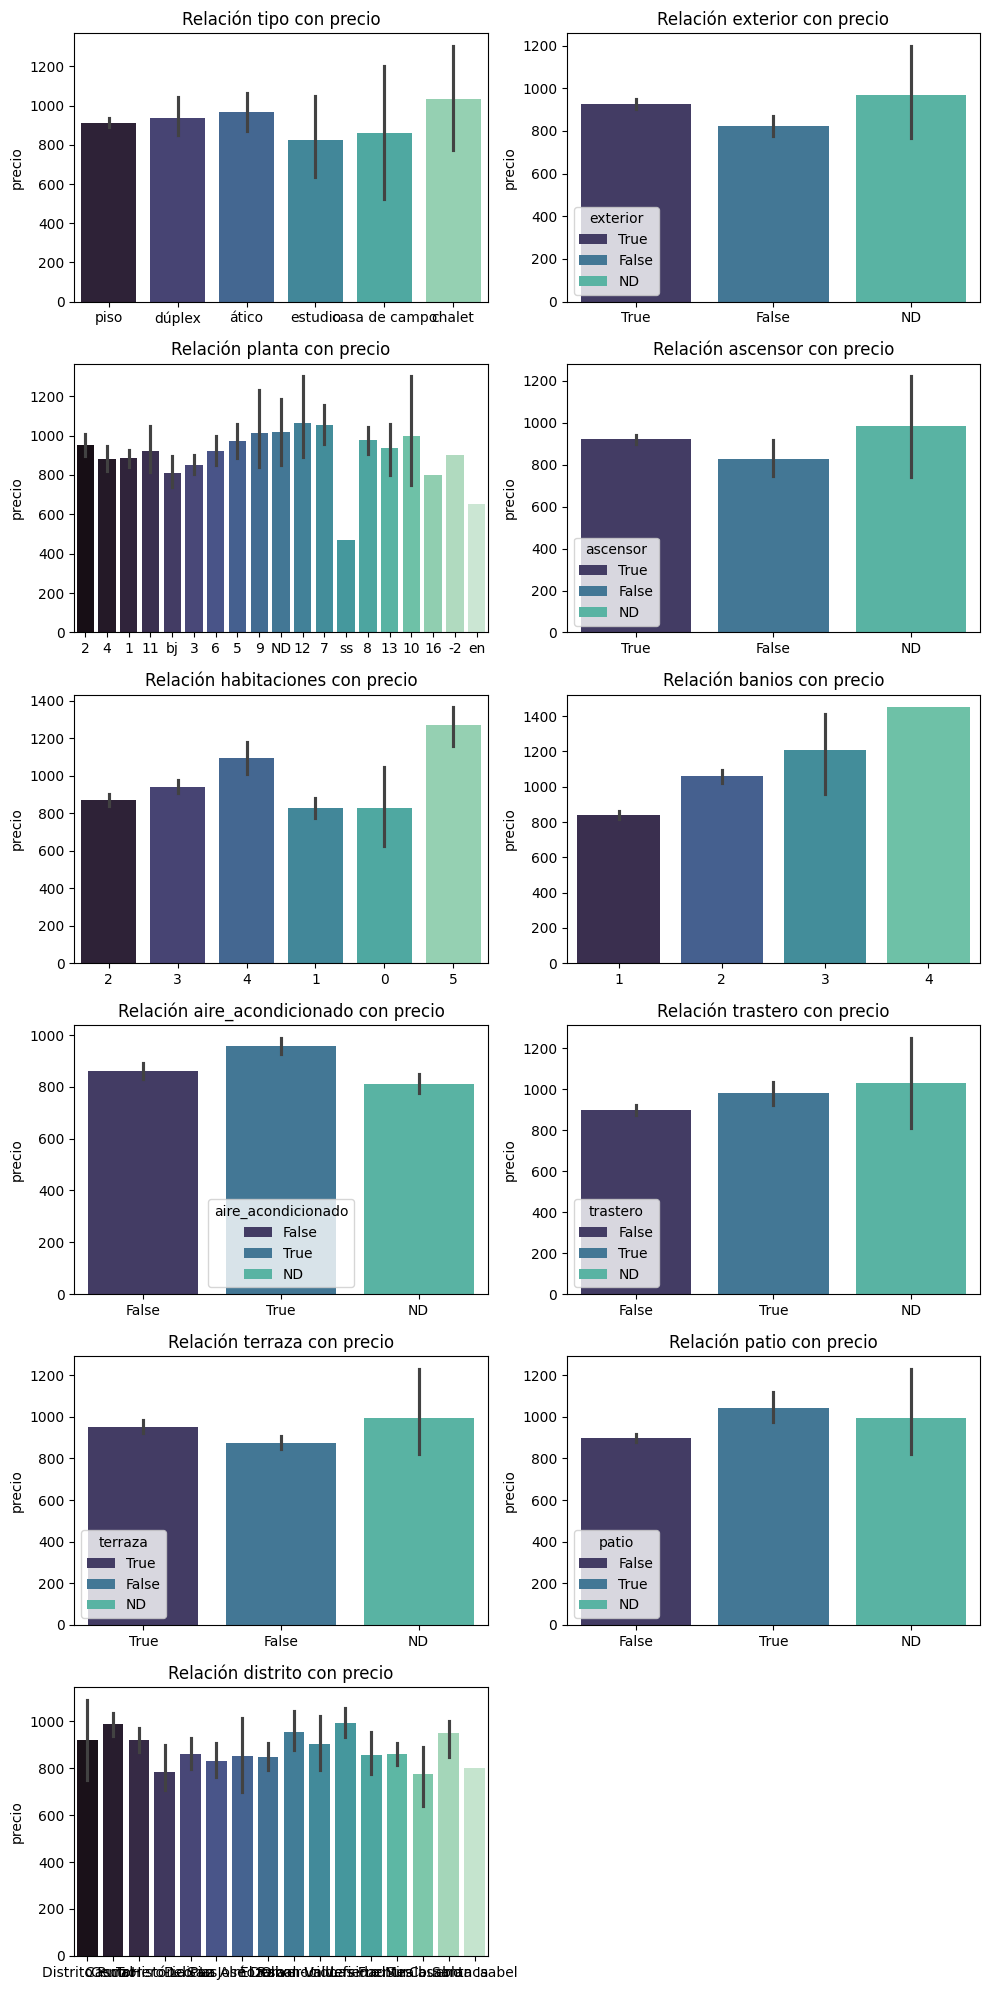

In [74]:
sa.visualizar_categorias(gdf_rent_join, lista_col_categ, "precio", tipo_grafica="barplot", tamanio_grafica=(10,20))

- Como hemos mencionado antes, en la mayoría de los casos, somos capaces de observar diferencias significativas, pero, para comprobarlo matemáticamente, tenemos a nuestro alcance tests estadísticos.

#### Diferencias entre categorías y orden
- Vamos a comprobar la normalidad y homocedasticidad, con el fin de identificar si son o no paramétricas, y comprobar diferencias.

- Para evaluar si hay diferencias entre las categorías de nuestras variables predictoras categóricas y dónde se encuentran, utilizaremos el test Kruskal, dado que todas las variables respuesta tienen más de 2 categorías.

- Tenemos valores booleanos en el conjunto, que transformaremos a string.

In [75]:
gdf_rent_join[lista_col_categ] = gdf_rent_join[lista_col_categ].astype(str)

In [62]:
sa.analizar_variables(gdf_rent_join, 'precio', 'shapiro')


__________________________

Estamos analizando la variable TIPO
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable tipo las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['piso', 'dúplex', 'ático', 'estudio', 'casa de campo', 'chalet']

Realizando test de K...
Estadístico de prueba: 5.446105366300246
Valor p: 0.36389182108706863
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,173.5000,0.9518,-392.5027,739.5027,casa de campo-chalet
1,74.1667,0.9987,-454.6797,603.0131,casa de campo-dúplex
2,-37.0556,1.0000,-565.9019,491.7908,casa de campo-estudio
3,49.1168,0.9997,-430.4554,528.6889,casa de campo-piso
4,102.6053,0.9921,-400.3013,605.5118,casa de campo-ático
5,-99.3333,0.9749,-476.6684,278.0018,chalet-dúplex
6,-210.5556,0.6008,-587.8907,166.7796,chalet-estudio
7,-124.3832,0.8512,-428.8380,180.0715,chalet-piso
8,-70.8947,0.9912,-410.9216,269.1322,chalet-ático
9,-111.2222,0.9184,-430.1286,207.6842,dúplex-estudio



__________________________

Estamos analizando la variable EXTERIOR
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable exterior las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'ND']

Realizando test de K...
Estadístico de prueba: 11.055191195699752
Valor p: 0.003975536394966097
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,148.0768,0.2147,-59.4305,355.5840,False-ND
1,105.5355,0.0046,27.3725,183.6986,False-True
2,-42.5412,0.8668,-238.9325,153.8501,ND-True



__________________________

Estamos analizando la variable PLANTA
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable planta las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['2', '4', '1', '11', 'bj', '3', '6', '5', '9', 'ND', '12', '7', 'ss', '8', '13', '10', '16', '-2', 'en']

Realizando test de K...
Estadístico de prueba: 46.56235952011423
Valor p: 0.000245478480200138
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-16.3846,1.0000,-842.0171,809.2478,-2-1
1,100.0000,1.0000,-847.3051,1047.3051,-2-10
2,21.6667,1.0000,-925.6384,968.9718,-2-11
3,163.3333,1.0000,-783.9718,1110.6384,-2-12
4,36.6667,1.0000,-910.6384,983.9718,-2-13
...,...,...,...,...,...
166,-368.6364,0.9916,-1225.5061,488.2333,ND-en
167,-548.6364,0.7328,-1405.5061,308.2333,ND-ss
168,-159.3333,1.0000,-1006.6288,687.9621,bj-en
169,-339.3333,0.9963,-1186.6288,507.9621,bj-ss



__________________________

Estamos analizando la variable ASCENSOR
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable ascensor las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'ND']

Realizando test de K...
Estadístico de prueba: 17.717079716188447
Valor p: 0.00014216249009973094
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,158.1331,0.2234,-66.4059,382.6721,False-ND
1,93.9991,0.0325,6.2104,181.7879,False-True
2,-64.1340,0.7537,-274.5727,146.3047,ND-True



__________________________

Estamos analizando la variable HABITACIONES
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable habitaciones las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['2', '3', '4', '1', '0', '5']

Realizando test de K...
Estadístico de prueba: 63.856161620185
Valor p: 1.9349638073558084e-12
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,1.9462,1.0000,-222.3250,226.2174,0-1
1,44.1462,0.9919,-171.3007,259.5931,0-2
2,115.8289,0.6427,-100.3707,332.0285,0-3
3,271.4673,0.0137,35.3125,507.6221,0-4
4,445.5556,0.0002,156.1020,735.0091,0-5
5,42.2000,0.7803,-50.1143,134.5144,1-2
6,113.8827,0.0076,19.8250,207.9404,1-3
7,269.5211,0.0000,135.8287,403.2136,1-4
8,443.6094,0.0000,229.3947,657.8240,1-5
9,71.6827,0.0436,1.2082,142.1572,2-3



__________________________

Estamos analizando la variable BANIOS
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable banios las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3', '4']

Realizando test de K...
Estadístico de prueba: 113.0358644966079
Valor p: 2.4373306526129595e-24
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,219.6016,0.0000,163.9488,275.2544,1-2
1,371.4505,0.0006,127.7392,615.1618,1-3
2,611.4505,0.0196,70.1653,1152.7358,1-4
3,151.8489,0.3841,-94.1171,397.8150,2-3
4,391.8489,0.2454,-150.4553,934.1531,2-4
5,240.0000,0.7226,-351.9390,831.9390,3-4



__________________________

Estamos analizando la variable AIRE_ACONDICIONADO
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable aire_acondicionado las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'True', 'ND']

Realizando test de K...
Estadístico de prueba: 20.56906489294335
Valor p: 3.415736098821034e-05
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-48.5209,0.9533,-435.7916,338.7497,False-ND
1,94.8893,0.0001,42.2983,147.4802,False-True
2,143.4102,0.6583,-243.4180,530.2384,ND-True



__________________________

Estamos analizando la variable TRASTERO
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable trastero las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'True', 'ND']

Realizando test de K...
Estadístico de prueba: 8.84311611658415
Valor p: 0.012015496848564726
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,133.3373,0.4945,-143.5271,410.2017,False-ND
1,81.7582,0.0144,13.2597,150.2567,False-True
2,-51.5791,0.9032,-333.7808,230.6226,ND-True



__________________________

Estamos analizando la variable TERRAZA
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable terraza las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'ND']

Realizando test de K...
Estadístico de prueba: 23.96877573627621
Valor p: 6.240889309820883e-06
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,119.2946,0.4953,-128.7008,367.2901,False-ND
1,77.1415,0.0018,24.3965,129.8866,False-True
2,-42.1531,0.9158,-290.3428,206.0366,ND-True



__________________________

Estamos analizando la variable PATIO
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable patio las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'True', 'ND']

Realizando test de K...
Estadístico de prueba: 20.70741155718608
Valor p: 3.187445098630616e-05
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,98.1688,0.6150,-147.3430,343.6807,False-ND
1,145.3147,0.0001,61.8220,228.8074,False-True
2,47.1458,0.9020,-209.1773,303.4690,ND-True



__________________________

Estamos analizando la variable DISTRITO
Para la columna precio, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable distrito las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Distrito Rural', 'Centro', 'Casco Histórico', 'Torrero-La Paz', 'Delicias', 'San José', 'La Almozara', 'El Rabal', 'Desconocido', 'Oliver-Valdefierro', 'Universidad', 'Las Fuentes', 'Sur', 'Miralbueno', 'Casablanca', 'Santa Isabel']

Realizando test de K...
Estadístico de prueba: 45.19989812344417
Valor p: 7.120413096530568e-05
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-28.0000,1.0000,-496.9409,440.9409,Casablanca-Casco Histórico
1,36.7500,1.0000,-432.1909,505.6909,Casablanca-Centro
2,-89.8235,1.0000,-563.9671,384.3201,Casablanca-Delicias
3,6.3889,1.0000,-491.3155,504.0933,Casablanca-Desconocido
4,-31.5000,1.0000,-556.8755,493.8755,Casablanca-Distrito Rural
...,...,...,...,...,...
115,-16.6667,1.0000,-857.9407,824.6074,Santa Isabel-Torrero-La Paz
116,192.3148,1.0000,-613.1438,997.7734,Santa Isabel-Universidad
117,-75.6667,1.0000,-434.3871,283.0538,Sur-Torrero-La Paz
118,133.3148,0.9347,-130.6963,397.3259,Sur-Universidad



__________________________



- Con ayuda de los tests y las visualizaciones, hemos identificado que existen diferencias significativas para casi todas las variables, por sus p-valores <0,05, siendo la única expeción el tipo de vivienda.

- El encoding consiste en asignar peso a las variables por el número de veces que aparecen en el conjunto o por su relación con la variable respuesta, por ejemplo. Pero en algunos casos, cuando entendemos que una variable tiene orden claro, podemos asignar nosotros mismos esos valores. Por ejemplo, para los valores booleanos, sabemos que True es más importante que False, así que 1 será True y -1 False, y cuando no tengamos ese dato, asignamos una importancia intermedia, en este caso 0.

- En el caso de ascensor, exterior, aire acondicionado, trastero, terraza y patio, que contienen valores booleanos (True-False) y otra categoría -ND-, los sustituiremos haciendo un mapeo con -1, 0 y 1, para dar o restar importancia. No hará falta utilizar otro método de encoding.

- Por su parte, para floor, sustituiremos los valores alfabéticos para que representen su importancia, sustituyendo de la siguiente manera:
    - st: -3
    - ss: -2
    - bj: -1
    - ND: 0
    - en: 0.5

In [76]:
dicc_sust_planta = {
    'st': -3, 
    'ss': -2,
    'bj': -1,
    'en': 0.5, 
    'ND': 0
}

gdf_rent_join['planta'] = gdf_rent_join['planta'].map(dicc_sust_planta).fillna(gdf_rent_join['planta']) 

In [77]:
lista_col_bools = ["ascensor", "exterior", "aire_acondicionado", "trastero", "terraza", "patio"]
 
for columna in lista_col_bools:
    gdf_rent_join[columna] = gdf_rent_join[columna].fillna('ND').astype(str).replace({"True": 1, "False": -1, "ND": 0})

In [78]:
gdf_rent_join.head(1)

,precio,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,distrito
0,750.00,piso,1,2,1,123.00,2,1,-1,-1,1,-1,Distrito Rural


- Ahora vamos a crear un diccionario con las variables a las que se les va a aplicar el encoding.
- Nos quedaremos con el target encoder por cuanto, asigna peso a las variables teniendo en cuenta la variable respuesta.

In [79]:
gdf_rent_join.reset_index(inplace=True, drop=True)

In [80]:
diccionario_encoding = {
    "onehot": [],
    "dummies": [],
    "ordinal": {},
    "label": [],
    "frequency": [],
    "target": ["tipo", "distrito"]
}

In [81]:
encoding = se.Encoding(gdf_rent_join, diccionario_encoding, "precio")

In [82]:
df_rent_enc, target_encoder = encoding.target_encoding()
df_rent_enc.head()

,precio,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,distrito
0,750.00,911.62,1,2,1,123.00,2,1,-1,-1,1,-1,915.12
1,1300.00,911.62,1,4,1,130.00,3,2,-1,-1,-1,-1,986.63
2,775.00,919.57,1,1,1,75.00,2,1,1,-1,1,-1,921.99
3,815.00,938.21,1,11,1,70.00,2,1,1,-1,1,-1,986.63
4,750.00,911.62,1,-1.00,1,95.00,4,2,1,-1,-1,-1,881.27


In [483]:
# with open('../transformers/target_encoder.pkl', 'wb') as f:
#     pickle.dump(target_encoder, f)

### Gestión de Outliers

- Transformamos temporalmente las columnas que deben ser categóricas pero durante el encoding se han convertido en numéricas.

In [83]:
df_rent_enc[['tipo', 'exterior', 'planta', 'ascensor', 'habitaciones', 'banios', 'aire_acondicionado', 'trastero', 'terraza', 'patio', 'distrito']] = df_rent_enc[['tipo', 'exterior', 'planta', 'ascensor', 'habitaciones', 'banios', 'aire_acondicionado', 'trastero', 'terraza', 'patio', 'distrito']].astype(str)

- Como primer paso, vamos a identificar los outliers de las features numéricas en boxplots:

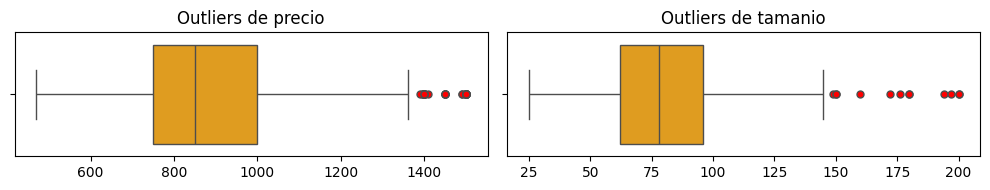

In [84]:
sp.detectar_outliers(df_rent_enc, tamano_grafica=(10,2))

- Vemos que, tenemos outliers en ambas features numéricas. Pese a que los outliers se encuentran dentro de los límites de la búsqueda.
- Para verlos numéricamente, vamos a recurrir al método IFO, que se usa en la detección de univariados, es decir, busca detectar valores atípicos basado únicamente en la distribución de esa variable.

In [85]:
df_rent_enc = sp.outliers_isolation_forest(df_rent_enc)

In [86]:
df_rent_enc, df_filtrado = sp.filtrar_outliers(df_rent_enc, 0.7, drop_indices=True)
df_rent_enc.reset_index(inplace=True, drop=True)

Se han filtrado 7 filas, que representan un 1.6% del dataframe original.


,precio,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,distrito,outliers_ifo_0.01_50,outliers_ifo_0.01_100,outliers_ifo_0.01_200,outliers_ifo_0.05_50,outliers_ifo_0.05_100,outliers_ifo_0.05_200,outliers_ifo_0.1_50,outliers_ifo_0.1_100,outliers_ifo_0.1_200
23,530.00,891.7916470853521,-1,1,-1,25.00,0,1,-1,-1,1,-1,915.1201058864708,-1,1,1,-1,-1,-1,-1,-1,-1
26,867.00,938.2113401678957,1,3,1,176.00,4,2,1,-1,1,-1,909.1914153896822,1,-1,1,-1,-1,-1,-1,-1,-1
212,1450.00,936.1551170511461,0,0.0,0,194.00,3,4,1,-1,1,1,862.4913405993424,-1,-1,-1,-1,-1,-1,-1,-1,-1
228,1090.00,938.2113401678957,1,8,1,200.00,2,2,1,1,1,1,933.0142489163833,-1,-1,-1,-1,-1,-1,-1,-1,-1
235,1450.00,911.6167512690355,1,3,1,180.00,4,2,1,-1,1,-1,989.7816198449632,1,1,-1,-1,-1,-1,-1,-1,-1


Se han eliminado 7 filas (2.0%) del dataframe original.


- Vemos que, filtrando los datos que son outliers en un 70% de las combinaciones, tenemos únicamente 7 registros. Estos outliers, hacen referencia al tamaño, teniendo en el límite inferior una vivienda de 25m2, y en el superior algunas de más de 180m2.

- Entendiendo este filtrado como razonable, vamos a eliminarlos del dataset, y hacer un reset de los índices.

### Estandarización

- Como primer paso, cambiamos a formato numérico todas nuestras columnas. Luego, creamos una variable que almacene esas features a estandarizar, que en este caso es sólamente el tamaño.

In [87]:
df_rent_enc = df_rent_enc.astype(float)
columnas_scaling = ['tamanio']

- Ahora aplicamos los escaladores.

In [88]:
df_escaladores_graf = ss.aplicar_escaladores(df_rent_enc, columnas_scaling, ['Robust', 'MinMax', 'Standard', 'Normalizer'])

- Los representamos visualmente.

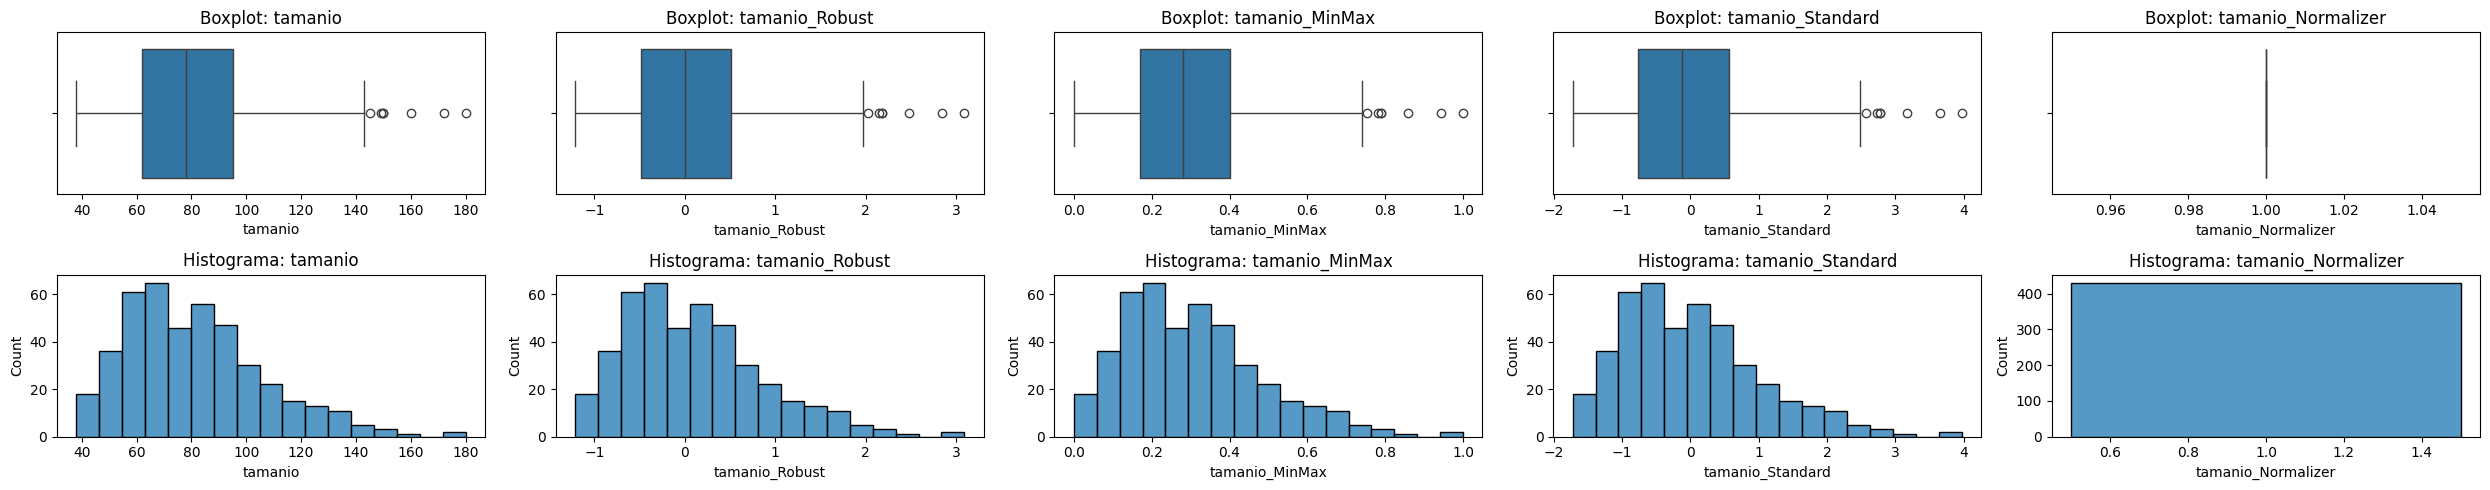

In [89]:
ss.graficar_escaladores(df_escaladores_graf, columnas_scaling, df_escaladores_graf.filter(like="_").columns)

- Nos quedaremos con el Standard Scaler, dado que, en las gráficas, cuando comparamos con los datos sin escalar, no se observan grandes diferencias entre el Robust, MinMax y el Standard (sabemos que por la naturaleza del Normalizer, tenemos resultados distintos), y lo que interesa en este caso es minimizar -"suavizar"- las diferencias, teniendo en este caso distribuciones aproximadamente normales. Además, apenas tenemos outliers.

In [90]:
df_rent_standard, scaler = ss.aplicar_escaladores(df_rent_enc, columnas_scaling, ["Standard"], return_scalers= True)
df_rent_standard.head(1)

,precio,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,distrito
0,750.00,911.62,1.00,2.00,1.00,1.69,2.00,1.00,-1.00,-1.00,1.00,-1.00,915.12


- Guardamos el objeto de scaling.

In [116]:
# with open('../transformers/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

- Con este paso, finaliza el preprocesamiento de los datos, de modo que, guardaremos el dataframe que llevamos al notebook #3, Modelos.

In [535]:
#df_rent_standard.to_pickle("../data/transformed/final_rent.pkl")

### Carga a Mongo

In [92]:
# bd = sm.conectar_a_mongo("ProyectoRentabilidad")

# sm.subir_dataframe_a_mongo(bd, df_rent_standard, "alquiler")

# bd.client.close()

DataFrame subido a la colección: alquiler
